In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error

In [385]:
def adjust_threshold(data, step_num, min_peak_distance):

    #data to dane z akcelerometru, step_num to ilość pików,
    #min_peak_distance to minimalna odległość między pikami
    mean = np.mean(data)
    dev = np.std(data)
    threshold = mean + 1.4 * dev
    
    peaks, _ = find_peaks(data, height=threshold, distance=min_peak_distance)
    
    iter_count = 0
    max_iter = 1000

    while len(peaks) != step_num and iter_count < max_iter:

        if len(peaks) < step_num:
            threshold -= 0.1 * dev
        else:
            threshold += 0.1 * dev
        
        peaks, _ = find_peaks(data, height=threshold, distance=min_peak_distance)

        iter_count += 1
    
    return peaks

In [396]:
def speed(step_num, peak, time_data, path):
    step_distance = np.zeros(step_num-3)
    step_speed = np.zeros((step_num)-3)
    step_time = np.zeros((step_num)-3)
    length = np.linspace(0, 40, (step_num)) #oszacowałam długość kroku na 50m/ilość kroków
    f = 3.6 #konwersja z m/s do km/h
    
    for i in range(0, (step_num)-3):
            step_distance[i] = length[i+1] - length[i]
        
            
            step_time[i] = time_data[peak[i+1]] - time_data[peak[i]]
            step_speed[i] = step_distance[i] / step_time[i]
        

    even = step_speed[::2]
    odd = step_speed[1::2]
    a = len(odd)
    step_mean = []
    for i in range(0, len(odd)):
        s = (even[i]+odd[i])/2
        s = s*f
        step_mean.append(s)
        

    loc = pd.read_csv(path)
    sensor_speed = loc['speed'].values
    
    sensor_speed = sensor_speed[:step_num]
    sensor_speed = sensor_speed*3
    new_index = np.linspace(0, len(step_mean) - 1, len(step_mean))
    sensor_speed = np.interp(new_index, np.arange(len(sensor_speed)), sensor_speed)

    flag = 0
    mse = mean_squared_error(step_mean, sensor_speed)
    for i in range(0, len(sensor_speed)):
         diff = np.abs(sensor_speed[i] - step_mean[i])
         if diff < np.std(step_mean):
              flag =flag + 1
    accuracy = flag*100/len(step_mean)

    
    
    return step_mean, even*f, odd*f, mse, flag, accuracy

In [392]:
def main(path_acc, path_ped, loc_path):
    acc = pd.read_csv(path_acc)
    time = acc['seconds_elapsed'].values
    x = acc['x'].values
    y = acc['y'].values
    z = acc['z'].values

    x = x[300:-300]
    y = y[300:-300]
    z = z[300:-300]
    z = -z
    time_data = time[300:-300]

    ped = pd.read_csv(path_ped)
    ped = ped['steps'].values
    step_num = ped[-4]
    peaks = 0
    peaks = adjust_threshold(z, step_num, min_peak_distance=20)
    step_mean, even, odd, mse, f, accuracy = speed(step_num, peaks, time_data, loc_path)
    
    flag = 0
    mn = np.mean(step_mean)
    std = np.std(step_mean)
    for i in range(0, len(step_mean)):
        if step_mean[i]<mn+std and step_mean[i]>mn-std:
            flag=flag+1
    skutecznosc = flag*100/len(step_mean)
    #print(flag, skutecznosc)
    

    
    return x, y, z, time_data, peaks, step_mean, even, odd, skutecznosc, mn, std, mse, f, accuracy

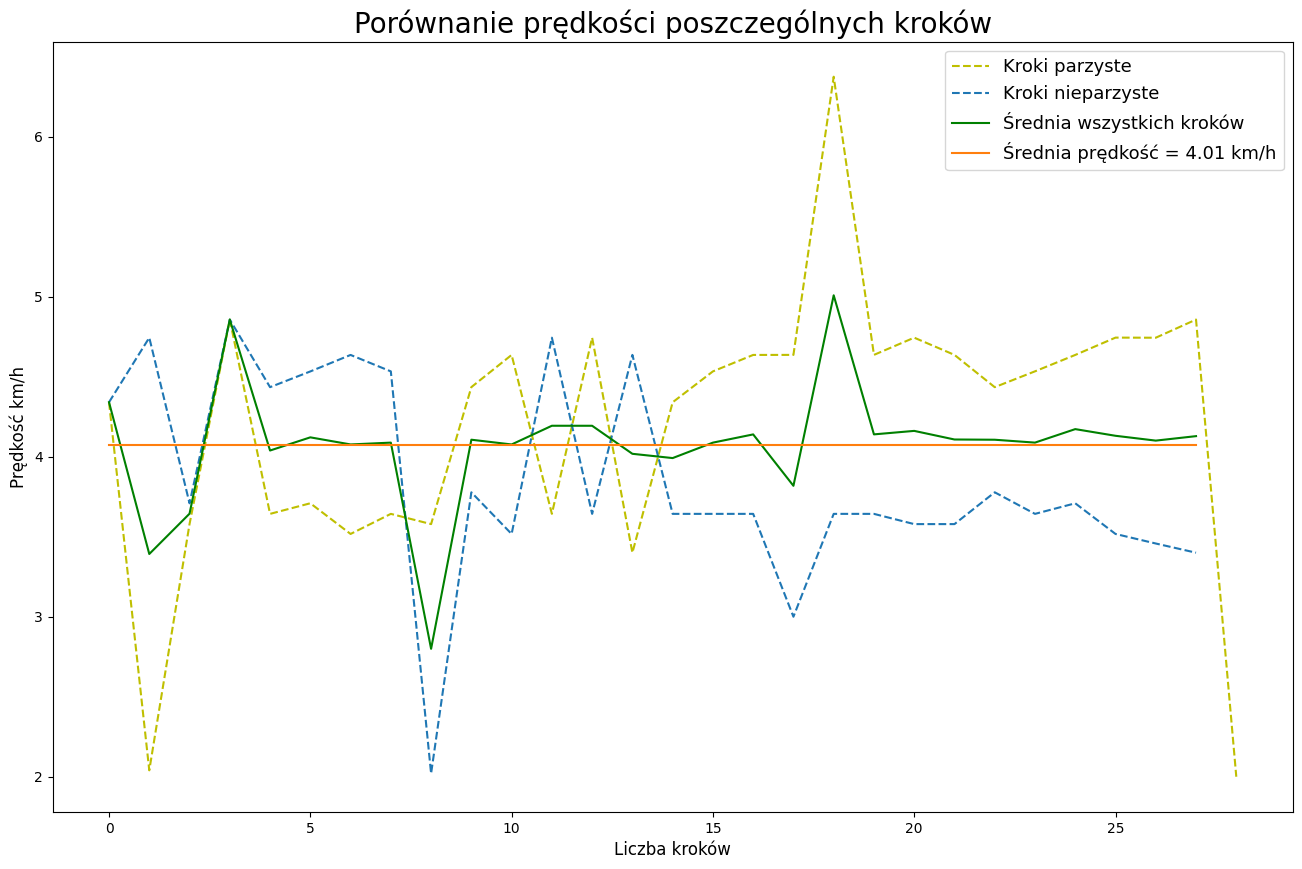

In [405]:
x, y, z, time, peaks, step_mean, even, odd, skutecznosc, mn, std, mse, f, accuracy = main("D:/IB/Telemedycyna/projekt-telemed/dane/20/Accelerometer.csv", "D:/IB/Telemedycyna/projekt-telemed/dane/20/Pedometer.csv", "D:/IB/Telemedycyna/projekt-telemed/dane/8/Location.csv")
m = np.mean(step_mean)
m2 = np.ones(len(step_mean))


plt.figure(figsize=(16, 10))
plt.plot(even, "y--", label = "Kroki parzyste")
plt.plot(odd, "--", label = "Kroki nieparzyste")
plt.plot(step_mean, "g", label = "Średnia wszystkich kroków")
plt.plot(m*m2, label= "Średnia prędkość = 4.01 km/h")
plt.xlabel("Liczba kroków", fontsize=12)
plt.ylabel("Prędkość km/h", fontsize=12)
plt.title("Porównanie prędkości poszczególnych kroków", fontsize=20)
plt.legend(fontsize=13)

In [399]:
acc_path = "D:/IB/Telemedycyna/projekt-telemed/dane/{}/Accelerometer.csv"
loc_path = "D:/IB/Telemedycyna/projekt-telemed/dane/{}/Location.csv"
ped_path = "D:/IB/Telemedycyna/projekt-telemed/dane/{}/Pedometer.csv"

step_mean_tab = []
mn_tab = []
std_tab = []
sk_tab = []
mse_tab = []
f_tab = []
plt.figure(figsize=(13, 60))

for j in range(11, 21):
    acc_path2 = acc_path.format(j)
    loc_path2 = loc_path.format(j-10)
    ped_path2 = ped_path.format(j)
    
    x, y, z,time, peaks, step_mean, even, odd, skutecznosc, mn, std, mse, f, accuracy = main(acc_path2, ped_path2, loc_path2)
    step_mean_tab.append(step_mean)
    sk_tab.append(skutecznosc)
    mn_tab.append(mn)
    std_tab.append(std)
    mse_tab.append(mse)
    f_tab.append(f)

    #plt.subplot(10, 1, j-10)
    #plt.plot(step_mean)
    #plt.title("Średnia prędkość chodu")
    #plt.xlabel("Ilość kroków")
    #plt.ylabel("Prędkość")


       
    


<Figure size 1300x6000 with 0 Axes>

1.388444104189439


Text(0, 0.5, 'Wielkość błędu')

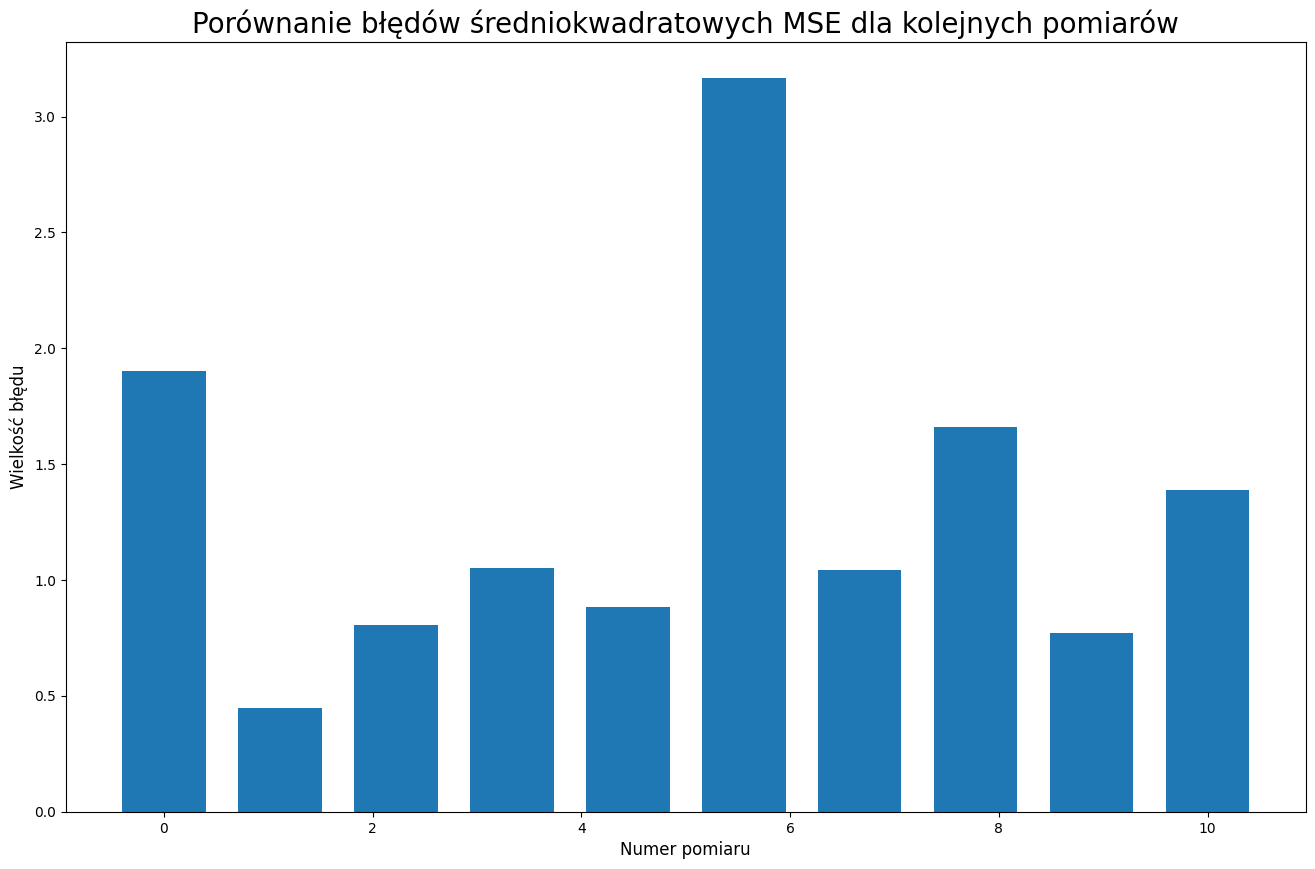

In [299]:
mse_tab = [1.9020984053886705,
0.44717262753159426,
0.805218836488474,
1.0523477012012274,
0.8853843774900192,
3.164498444230281,
1.044572722600581,
1.6612354857379237,
0.7717736552678744,
1.388444104189439]
print(np.mean(mse))
ab = np.linspace(0, 10, 10)

plt.figure(figsize=(16, 10))
plt.bar(ab, mse_tab)
plt.title('Porównanie błędów średniokwadratowych MSE dla kolejnych pomiarów', fontsize=20)
plt.xlabel('Numer pomiaru', fontsize=12)
plt.ylabel('Wielkość błędu', fontsize=12)

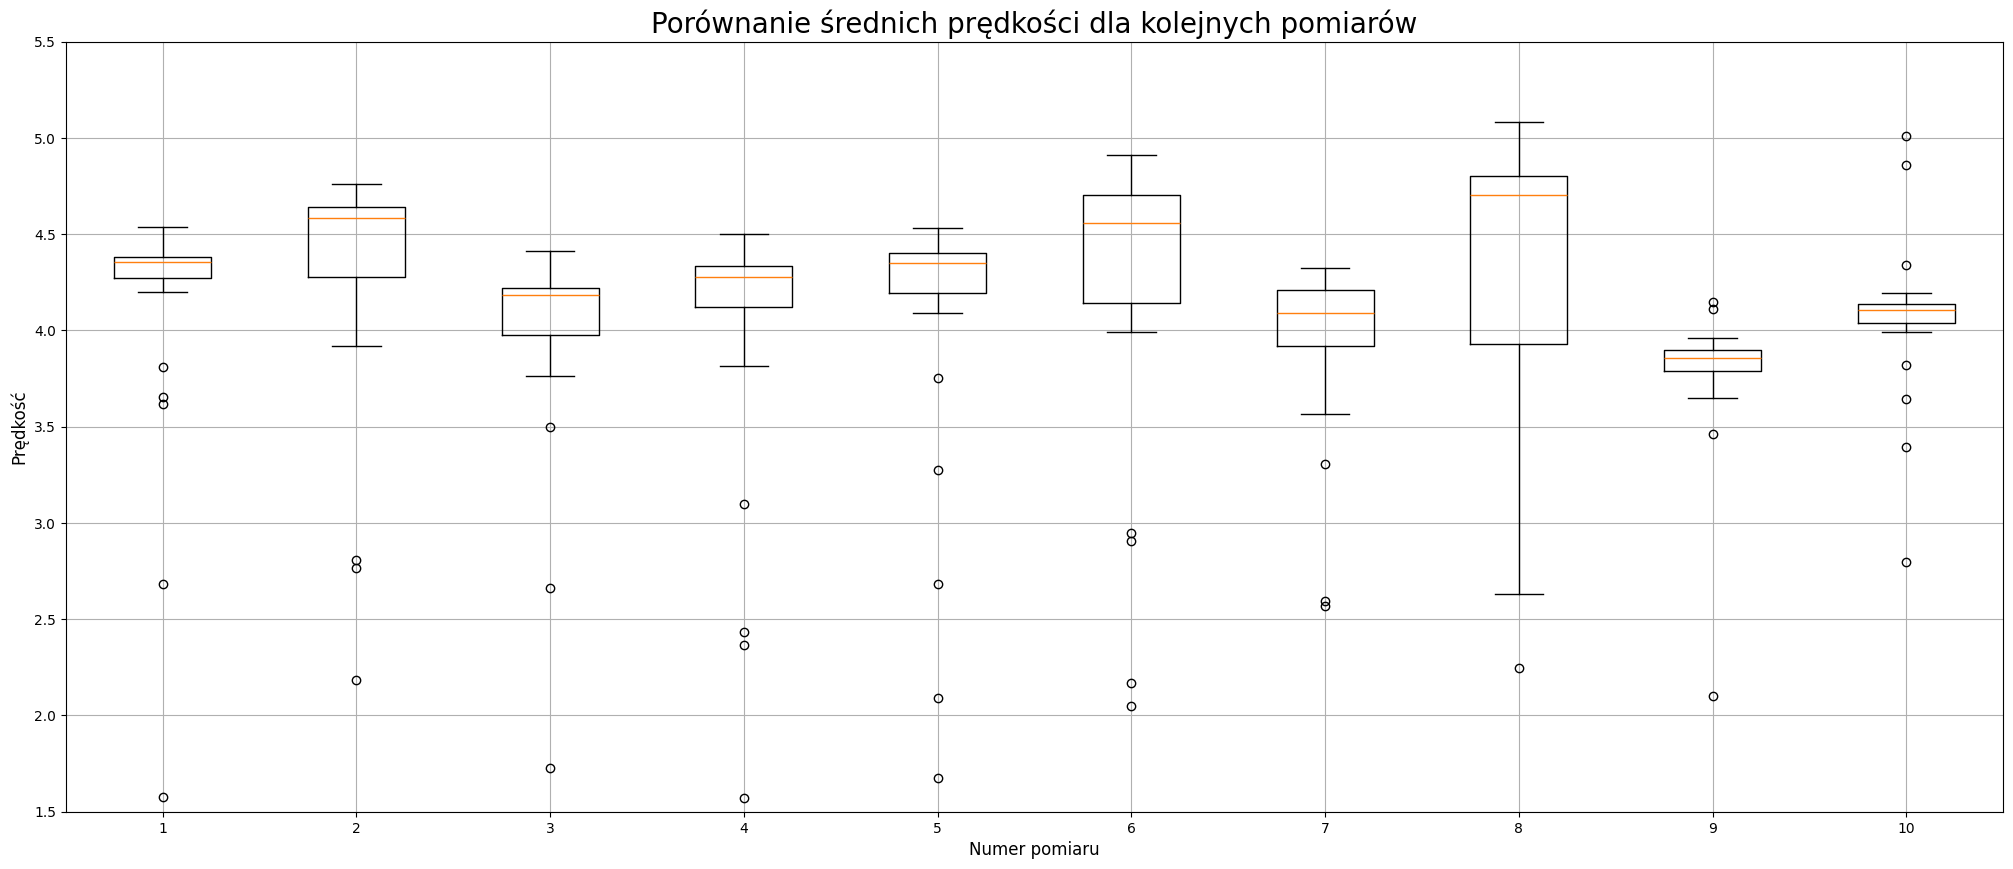

In [88]:
step2 = []
all_iterations = []

for i in range(11, 21):
    acc_path2 = acc_path.format(i)
    ped_path2 = ped_path.format(i)
    z, peaks, step_mean, even, odd = main(acc_path2, ped_path2)
    
    step2_iter = []
    for j in range(len(step_mean)):
        

            step2_iter.append(step_mean[j])
    
    all_iterations.append(step2_iter)

plt.figure(figsize=(25, 10))
plt.boxplot(all_iterations, positions=np.arange(1, 11))
plt.title('Porównanie średnich prędkości dla kolejnych pomiarów', fontsize=20)
plt.xlabel('Numer pomiaru', fontsize=12)
plt.ylabel('Prędkość', fontsize=12)
plt.ylim(1.5, 5.5)
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Prędkość chodu')

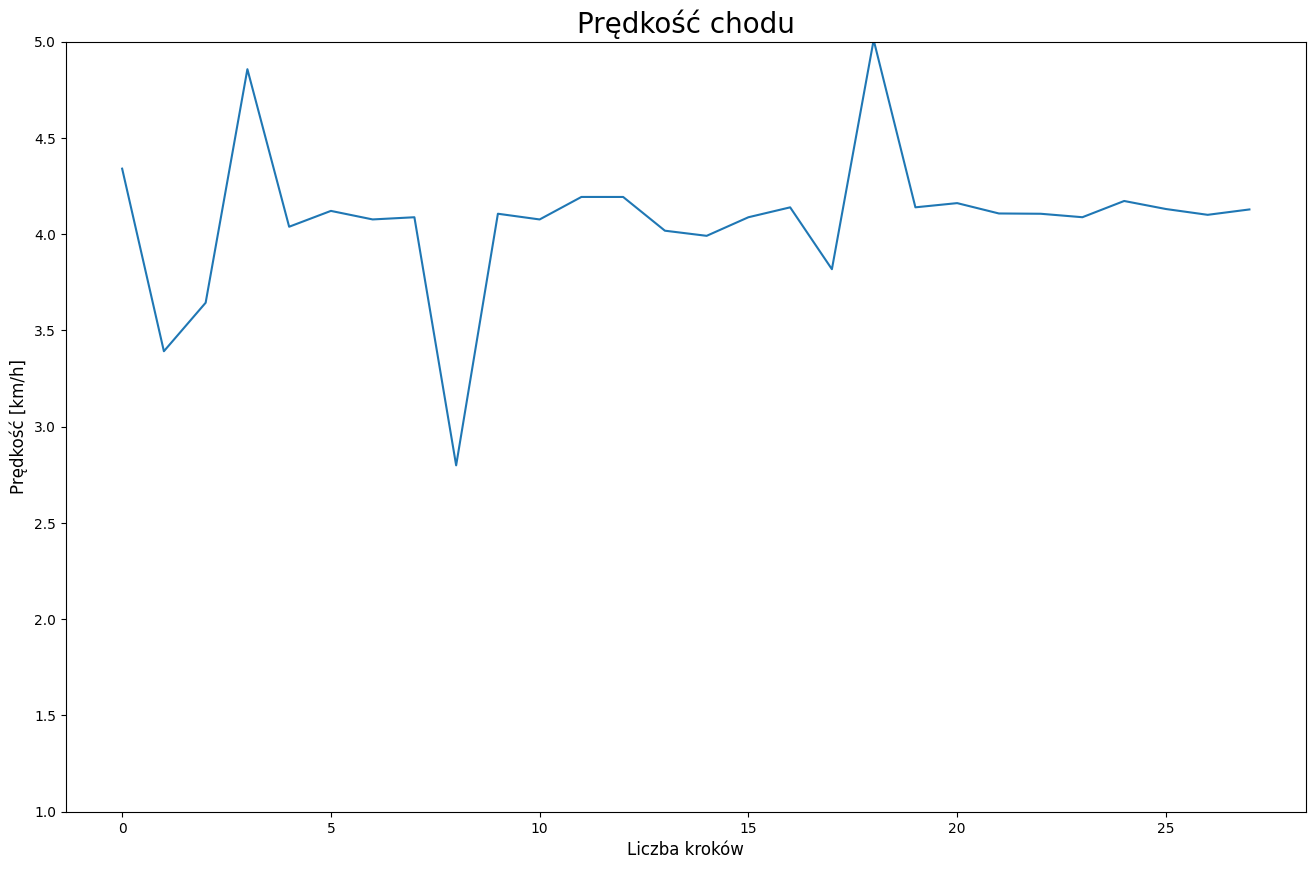

In [403]:
plt.figure(figsize=(16, 10))
plt.plot(step_mean)
plt.ylim(1, 5)
plt.xlabel("Liczba kroków", fontsize=12)
plt.ylabel("Prędkość [km/h]", fontsize=12)
plt.title("Prędkość chodu", fontsize=20)